# Sharded Tests

## Bug with encoding/gob

Spent a lot of time finding a bug the server routine: sometimes the server accepted a signature of a request, sometimes the server rejected the request.

The bug was that the hash was calculated the wrong way: the pipeline to create a hash from a struct was the following:

```
sha3(gobEncoding(go struct))

```

it turns out that `encoding/gob` is not deterministic: Let `s` and `s'` be two go structs. There can be two gob encodings `gobEncoding(s)` and `gobEncoding(s')` where `gobEncoding(s) != gobEncoding(s')` but `s == s'`. The reason is unknown. The reason could be slicing, reordering, compression.

This could happen for example when `gobEncoding(s)` is transferred over the the `net/rpc` library.

### Fixing the bug: construct hashing method where each field in the struct is hashed **explicitly**

Before:

![./gob-before.png](./gob-before.png)

After:

![./gob.png](./gob.png)

## Benchmarks

### Server routine only, no networking, no sharding

This is a basic sanity check to ensure that the changes have not impacted the performance of the server routine.

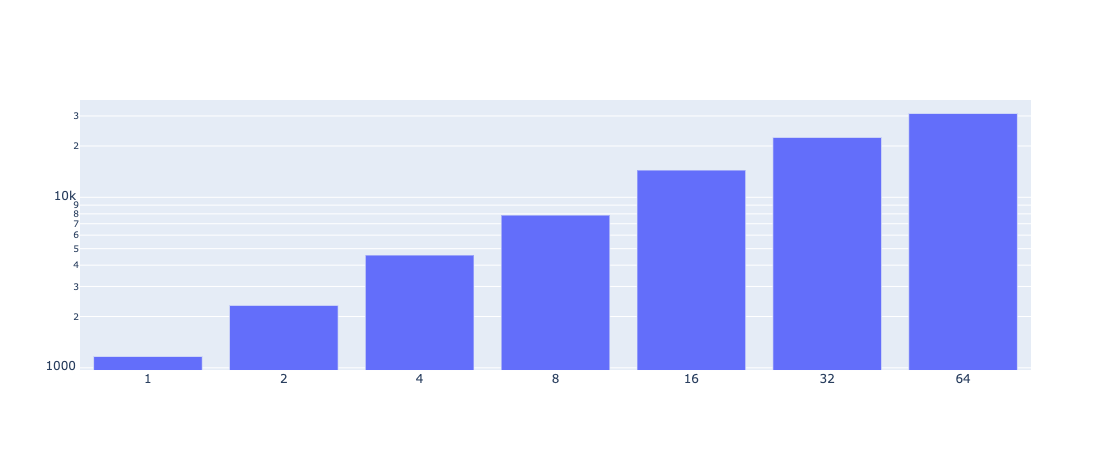

In [16]:
import plotly.graph_objects as go
import numpy as np


d = pd.read_csv("sharded-tests/data.csv")

fig = go.Figure(data=[
    go.Bar(name='tx/s', x=d["cpus"], y=1/(d["nsop"]*10**-9))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(xaxis_type='category', yaxis_type='log')
fig.show()

## Sharded tests

10 clients, 5 servers. Clients choose random addresses and it's sharded to 5 servers.

**Separate**:

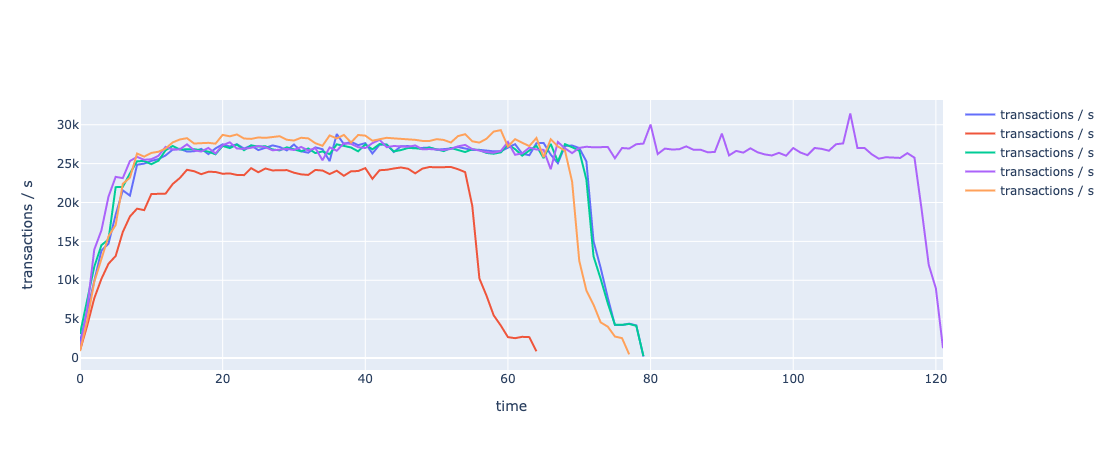

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

fig = make_subplots(specs=[[{"secondary_y": False}]])

for x in range(0, 5):
    d = pd.read_csv(f"sharded-tests/benches/server{x}.csv")
    fig.add_trace(
        go.Scatter(y=d['tx'], name="transactions / s"),
        secondary_y=False,
    )

#fig.add_trace(
#    go.Scatter(y=d1['cpu_util'], name="cpu utilization %"),
#    secondary_y=True,
#)


fig.update_xaxes(title_text="time")
fig.update_yaxes(title_text="transactions / s", secondary_y=False)
#fig.update_yaxes(title_text="cpu utilization %", secondary_y=True)

fig.show()

**Combined:**

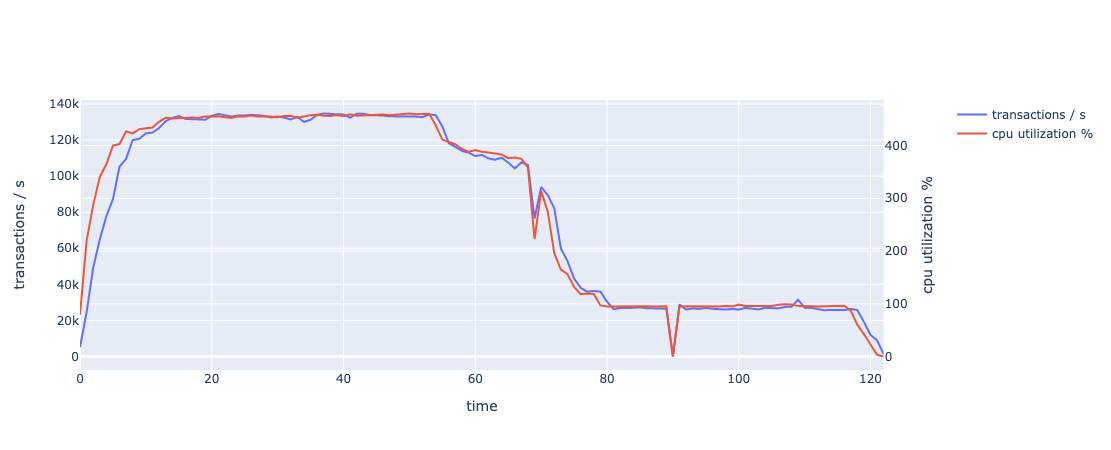

In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import functools 

fig = make_subplots(specs=[[{"secondary_y": True}]])

dfs = []

for x in range(0, 5):
    df = pd.read_csv(f"sharded-tests/benches/server{x}.csv")
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.set_index('time')
    df = df.resample("1s").sum()
    dfs.append(df)

d = pd.concat(dfs).groupby("time").sum()

fig.add_trace(
    go.Scatter(y=d['tx'], name="transactions / s"),
    secondary_y=False,
)
    
fig.add_trace(
    go.Scatter(y=d['cpu_util'], name="cpu utilization %"),
    secondary_y=True,
)


fig.update_xaxes(title_text="time")
fig.update_yaxes(title_text="transactions / s", secondary_y=False)
fig.update_yaxes(title_text="cpu utilization %", secondary_y=True)

fig.show()